## 1 - Exploring the Tensorflow Library

To start, you will import the library:

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

# Loading the Images 

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and inspect the dataset
### Retrieve the images
Before you start any training, you'll need a set of images to teach the network about the new classes you want to recognize. You've created an archive of creative-commons licensed flower photos to use initially.

In [4]:
import pathlib
data_root = pathlib.Path('/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images')
print(data_root)

/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images


In [5]:
for item in data_root.iterdir():
  print(item)

/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Rock
/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Spock
/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Scissor
/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Paper
/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Lizard


In [6]:
import random
random.seed(1)
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print("Image count:", image_count)
print("first teen path", all_image_paths[:10])

Image count: 4768
first teen path ['/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Scissor/Scissor01204.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Paper/Paper00419.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Rock/Rock00537.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Rock/Rock00502.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Spock/Spock00517.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Paper/Paper00636.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Rock/Rock00241.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Paper/Paper00662.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Spock/Spock00377.png', '/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Rock/Rock00551.png']


In [7]:
train_split = 0.8

train_image_paths = all_image_paths[0 : int(image_count*train_split)]
print("train count", len(train_image_paths))
test_image_paths = all_image_paths[int(image_count*train_split) : ]
print("test count", len(test_image_paths))
print("total count", len(train_image_paths) + len(test_image_paths))

train count 3814
test count 954
total count 4768


## Determine the label for each image

List the available labels:


In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Lizard', 'Paper', 'Rock', 'Scissor', 'Spock']

Assign an index to each label:

In [9]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Lizard': 0, 'Paper': 1, 'Rock': 2, 'Scissor': 3, 'Spock': 4}

Create a list of every file, and its label index

In [10]:
train_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in train_image_paths]
test_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in test_image_paths]
print("First 10 labels indices in train: ", train_image_labels[:10])
print("First 10 labels indices in test: ", test_image_labels[:10])
print(type(train_image_labels))


First 10 labels indices in train:  [3, 1, 2, 2, 4, 1, 2, 1, 4, 2]
First 10 labels indices in test:  [1, 2, 3, 0, 1, 4, 3, 1, 4, 2]
<class 'list'>


## Load and format the images

TensorFlow includes all the tools you need to load and process images:

In [11]:
img_path = train_image_paths[0]
img_path

'/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Scissor/Scissor01204.png'

here is the raw data:

In [12]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x9...


Decode it into an image tensor:

In [13]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(400, 400, 3)
<dtype: 'uint8'>


Normalize it for your model:

In [14]:
img_final = tf.image.resize(img_tensor, [96, 96])
img_final = img_final/255
print(type(img_final))
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

<class 'tensorflow.python.framework.ops.EagerTensor'>
(96, 96, 3)
0.003921569
1.0


Wrap up these up in simple functions for later.

In [15]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [96, 96])
    image /= 255  # normalize to [0,1] range

    return image

In [16]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

/home/adrian/Desktop/RockScissorsPaperLizardSpock/DataSet/Images/Scissor/Scissor01204.png



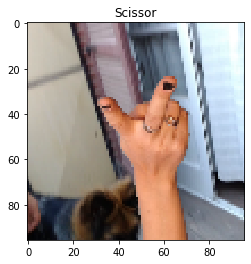

In [17]:
import matplotlib.pyplot as plt

img_path = train_image_paths[0]
label = train_image_labels[0]
print(img_path)
plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

# Build a tf.data.Dataset
## A dataset of images
The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

Slicing the array of strings results in a dataset of strings:


In [18]:
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_paths)
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)

The output_shapes and output_types fields describe the content of each item in the dataset. In this case it is a set of scalar binary-strings

In [19]:
print('shape: ', repr(train_path_ds.output_shapes))
print('type: ', train_path_ds.output_types)
print()
print(train_path_ds)

W0911 23:28:05.799154 140698025822016 deprecation.py:323] From <ipython-input-19-dc2b81ba61e8>:1: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0911 23:28:05.801636 140698025822016 deprecation.py:323] From <ipython-input-19-dc2b81ba61e8>:2: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


Now create a new dataset that loads and formats images on the fly by mapping preprocess_image over the dataset of paths.

In [20]:
train_image_ds = train_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

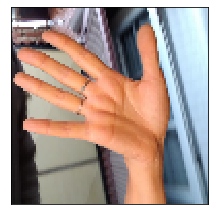

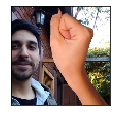

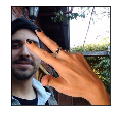

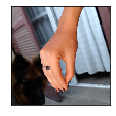

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(test_image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.show()

### A dataset of (image, label) pairs
Using the same from_tensor_slices method you can build a dataset of labels

In [22]:
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_image_labels, tf.int64))
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_image_labels, tf.int64))

In [23]:
for label in train_label_ds.take(10):
    print(label_names[label.numpy()])

Scissor
Paper
Rock
Rock
Spock
Paper
Rock
Paper
Spock
Rock


Since the datasets are in the same order you can just zip them together to get a dataset of (image, label) pairs.

In [24]:
train_image_label_ds = tf.data.Dataset.zip((train_image_ds, train_label_ds))
test_image_label_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))

The new dataset's shapes and types are tuples of shapes and types as well, describing each field:

In [25]:
print(test_image_label_ds)

<DatasetV1Adapter shapes: ((96, 96, 3), ()), types: (tf.float32, tf.int64)>


Note: When you have arrays like all_image_labels and all_image_paths, an alternative to using tf.data.dataset.Dataset.zip is slicing the pair of arrays.

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))


# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

train_image_label_ds = train_ds.map(load_and_preprocess_from_path_label)
test_image_label_ds = test_ds.map(load_and_preprocess_from_path_label)

unpack the dataset

### Basic methods for training
To train a model with this dataset you will want the data:

    To be well shuffled.
    To be batched.
    To repeat forever.
    To have batches available as soon as possible.

These features can be easily added using the tf.data api.


In [27]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = train_image_label_ds.shuffle(buffer_size=image_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
train_ds


BATCH_VAL_SIZE = 32
# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
test_ds = train_image_label_ds.shuffle(buffer_size=image_count)
test_ds = train_ds.repeat()
test_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
test_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds


<DatasetV1Adapter shapes: ((?, 96, 96, 3), (?,)), types: (tf.float32, tf.int32)>

There are a few things to note here:

1. The order is important.

  * A `.shuffle` *after* a `.repeat` would shuffle items across epoch boundaries (some items will be seen twice before others are seen at all).
  * A `.shuffle` *after* a `.batch` would shuffle the order of the batches, but not shuffle the items across batches.

1. Use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.

1. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.

1. The shuffled dataset doesn't report the end of a dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat`, causing another wait for the shuffle-buffer to be filled.

This last point, as well as the order of `.shuffle` and `.repeat`, can be addressed by using the `tf.data.Dataset.apply` method with the fused `tf.data.experimental.shuffle_and_repeat` function:

  * For more on ordering the operations, see [Repeat and Shuffle](https://www.tensorflow.org/guide/performance/datasets#repeat_and_shuffle) in the Input Pipeline Performance guide.

### Pipe the dataset to a model

Fetch a copy of MobileNet v2 from `tf.keras.applications`.

This will be used for a simple transfer learning example.

Set the MobileNet weights to be non-trainable:

In [28]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3), alpha = 0.35, include_top=False)
mobile_net.trainable=False

This model expects its input to be normalized to the `[-1,1]` range:

```
help(keras_applications.mobilenet_v2.preprocess_input)
```

<pre>
...
This function applies the "Inception" preprocessing which converts
the RGB values from [0, 255] to [-1, 1]
...
</pre>

So before passing data to the MobileNet model, you need to convert the input from a range of [0,1] to [-1,1].

In [29]:
def change_range(image,label):
  return 2*image-1, label

train_ds_range = train_ds.map(change_range)
test_ds_range = test_ds.map(change_range)

Because of this output shape, build a model wrapped around MobileNet using tf.keras.layers.GlobalAveragePooling2D to average over the space dimensions before the output tf.keras.layers.Dense layer:

In [30]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names), activation = 'softmax')])

Compile the model to describe the training procedure:

In [31]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

There are 2 trainable variables: the Dense weights and bias:

In [32]:
len(model.trainable_variables)

2

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.35_96 (Model)  (None, 3, 3, 1280)        410208    
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 416,613
Trainable params: 6,405
Non-trainable params: 410,208
_________________________________________________________________


Train the model.

Normally you would specify the real number of steps per epoch, but for demonstration purposes only run 3 steps.


In [34]:
steps_per_epoch=tf.ceil(len(train_image_paths)/BATCH_SIZE).numpy()
steps_validation = tf.ceil(len(test_image_paths)/BATCH_VAL_SIZE).numpy()
print("step per epoch", steps_per_epoch)
print("validation Steps", steps_validation)

step per epoch 120.0
validation Steps 30.0


In [35]:
history = model.fit(train_ds_range, epochs=10, 
          steps_per_epoch=steps_per_epoch,
          validation_data=test_ds_range,
          validation_steps = steps_validation)

Epoch 1/10


W0911 23:29:23.156828 140698025822016 deprecation.py:323] From /home/adrian/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


120/120 [==============================] - 123s 1s/step - loss: 0.8486 - acc: 0.6685 - val_loss: 1.0630 - val_acc: 0.4990
Epoch 2/10
120/120 [==============================] - 46s 383ms/step - loss: 0.4444 - acc: 0.8404 - val_loss: 0.8622 - val_acc: 0.6229
Epoch 3/10
120/120 [==============================] - 46s 380ms/step - loss: 0.3462 - acc: 0.8826 - val_loss: 1.2020 - val_acc: 0.4781
Epoch 4/10
120/120 [==============================] - 46s 384ms/step - loss: 0.3006 - acc: 0.8943 - val_loss: 0.8906 - val_acc: 0.6125
Epoch 5/10
120/120 [==============================] - 47s 392ms/step - loss: 0.2692 - acc: 0.9078 - val_loss: 0.7791 - val_acc: 0.6583
Epoch 6/10
120/120 [==============================] - 49s 409ms/step - loss: 0.2359 - acc: 0.9208 - val_loss: 0.9964 - val_acc: 0.5781
Epoch 7/10
120/120 [==============================] - 46s 383ms/step - loss: 0.2171 - acc: 0.9268 - val_loss: 0.9656 - val_acc: 0.6042
Epoch 8/10
120/120 [==============================] - 46s 382ms/step

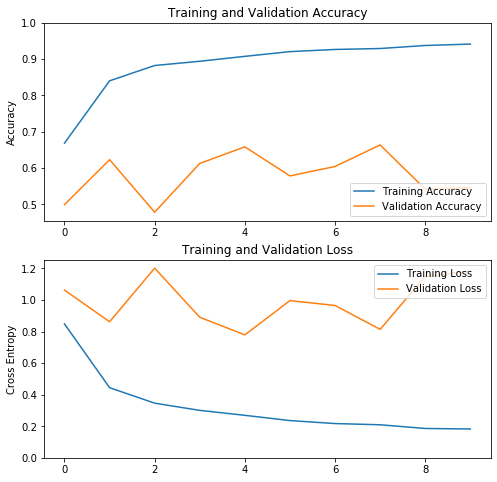

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()